[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)



# 代理（Agent）

## 评论（Review）

We built a router.

我们构建了一个路由器。

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

*我们的聊天模型将根据用户输入决定是否进行工具调用* 我们使用条件边来路由到一个节点，该节点将调用我们的工具或直接结束

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## 目标（Goals）

Now, we can extend this into a generic agent architecture.

现在，我们可以将其扩展为一个通用的代理架构。

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

在上面的路由中，我们调用了模型，并且如果它选择调用工具，我们会将一个 `ToolMessage` 返回给用户。

但是，如果我们简单地将那个 `ToolMessage` * 返回给模型*，会怎么样呢？

We can let it either (1) call another tool or (2) respond directly.

我们可以让它要么 (1) 调用另一个工具，要么 (2) 直接响应。

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

这是 [ReAct](https://react-lm.github.io/) 的直觉所在，这是一种通用代理架构。

*`act` - 让模型调用特定工具* `observe` - 将工具输出传递回模型  
* `reason` - 让模型对工具输出进行推理，以决定下一步操作（例如，调用另一个工具或直接响应）

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

这种 [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) 可以应用于许多类型的工具。

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

在这里，我们将使用 [LangSmith](https://docs.smith.langchain.com/) 用于 [tracing](https://docs.smith.langchain.com/concepts/tracing)。

We'll log to a project, `langchain-academy`. 

我们将记录到一个项目中，`langchain-academy`。



In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [4]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

# 在这个 ipynb 文件中，我们将并行工具调用（parallel tool calling）设置为 false，因为数学计算通常是按顺序执行的，并且这次我们有3个可以进行数学计算的工具。
# OpenAI 模型为了效率，默认进行并行工具调用，详情请参阅 `https://python.langchain.com/docs/how_to/tool_calling_parallel/`
# 不妨尝试一下，看看模型在处理数学方程式时的表现！
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

让我们创建我们的LLM，并用整体期望的代理行为来提示它。



In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="你是一个乐于助人的助手，负责对一组输入执行算术运算。")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

与之前一样，我们使用 `MessagesState` 并定义一个 `Tools` 节点，其中包含我们的工具列表。

The `Assistant` node is just our model with bound tools.

`Assistant` 节点只是我们带有绑定工具的模型。

We create a graph with `Assistant` and `Tools` nodes.

我们创建了一个包含 `Assistant` 和 `Tools` 节点的图。

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

我们添加了 `tools_condition` 边，根据 `Assistant` 是否调用工具，将其路由到 `End` 或 `Tools`。

Now, we add one new step:

现在，我们新增一个步骤：

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

我们将 `Tools` 节点 *回环* 连接到 `Assistant`，从而形成一个回路。

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

*在 `assistant` 节点执行后，`tools_condition` 检查模型的输出是否为工具调用。* 如果是工具调用，则流程被导向至 `tools` 节点。  
*`tools` 节点重新连接到 `assistant`。* 只要模型决定调用工具，此循环就会继续。  
* 如果模型的响应不是工具调用，则流程被导向至结束，终止该过程。



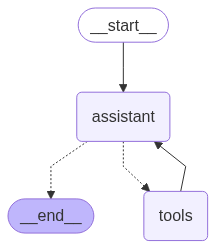

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="将3和4相加。将结果乘以2。再将结果除以5。")]
messages = react_graph.invoke({"messages": messages})

/root/.pyenv/versions/3.11.1/lib/python3.11/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=fc40d796-2dd7-4a98-8323-6fb050d24d34; trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=d8772bf0-77be-4e4e-910a-64d7b9292bf1; trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=c35f8fb6-6d07-49ec-b2f2-ae42d16a4c20
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=

Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=c73d319a-ff82-4241-9a39-11ffc88cc606; trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=72855a9d-4b2e-4207-87fd-97523068b953; trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=72855a9d-4b2e-4207-87fd-97523068b953; trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=cdad6b16-0ab0-4609-82be-1ec71d5f0d68; trace=fc40d796-2dd7-4a98-8323-6fb050d24d34,id=fc40d796-2dd7-4a98-8323-6fb050d24d34


In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

将3和4相加。将结果乘以2。再将结果除以5。
================================== Ai Message ==================================
Tool Calls:
  add (call_6c69898dba0342bfbb889e)
 Call ID: call_6c69898dba0342bfbb889e
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_9940e7603ecf4a13a5f2fb)
 Call ID: call_9940e7603ecf4a13a5f2fb
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_d48fbbe205a14dfbaa3500)
 Call ID: call_d48fbbe205a14dfbaa3500
  Args:
    a: 14
    b: 5
================================= Tool Message =================================
Name: divide

2.8
==============

## 朗史密斯（LangSmith）

We can look at traces in LangSmith.

我们可以在 LangSmith 中查看轨迹。

